# Bicycle Sharing Stations Bordeaux

Analyze the daily profile for each station from 2017-07-09 to 2017-09-26.

## Some Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.cluster import KMeans

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Watermark for the versions of used libs

In [5]:
%load_ext watermark

In [6]:
%watermark -d -v -p numpy,pandas,sklearn,matplotlib,seaborn -g -m -w

2017-11-20 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
sklearn 0.18.1
matplotlib 2.0.2
seaborn 0.8.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-98-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 213e0344fc447e7cc4c6119eec239ca29346e680
watermark 1.5.0


## Load Data

In [8]:
# Timeseries data
DATA = "../data/bordeaux.csv"

In [10]:
raw = pd.read_csv(DATA, parse_dates=['ts'])

In [11]:
raw.head()

,gid,ident,type,name,state,available_stand,available_bike,ts
0,83,1,VLS,Meriadeck,CONNECTEE,18,2,2017-07-09 00:03:04
1,84,2,VLS,St Bruno,CONNECTEE,7,13,2017-07-09 00:03:04
2,41,3,VLS,Place Tartas,CONNECTEE,17,1,2017-07-09 00:03:04
3,42,4,VLS,St Seurin,CONNECTEE,18,2,2017-07-09 00:03:04
4,43,5,VLS,Place Gambetta,CONNECTEE,37,2,2017-07-09 00:03:04


## Some Cleaning

In [12]:
print(raw.shape)

(3761880, 8)


* Get only `CONNECTEE` station (i.e. not closed)
* Rename some columns
* Drop duplicates

In [13]:
data = (raw.copy()
        .query('state == "CONNECTEE"')
        .drop(['gid', 'available_stand', 'type', 'state'], axis=1)
        .rename_axis({"available_bike": "bikes", "ident": "station"}, axis=1)
        .drop_duplicates()
        .sort_values(["station", "ts"]))

In [14]:
print(data.shape)
data.head()

(3607233, 4)


,station,name,bikes,ts
0,1,Meriadeck,2,2017-07-09 00:03:04
174,1,Meriadeck,2,2017-07-09 00:04:04
348,1,Meriadeck,2,2017-07-09 00:09:04
522,1,Meriadeck,2,2017-07-09 00:14:03
696,1,Meriadeck,2,2017-07-09 00:19:04


## Timeseries resampling

Get data every 5 minutes.

In [15]:
df = (data.set_index("ts")
      .groupby("station")["bikes"]
      .resample("5T")
      .mean()
      .bfill()
      .unstack(0))

In [16]:
print(df.shape)
df.head()

(22932, 171)


station,1,2,3,4,5,6,7,8,9,10,...,165,166,167,168,169,170,171,172,173,174
ts,,,,,,,,,,,,,,,,,,,,,
2017-07-09 00:00:00,2.0,13.0,1.0,2.0,3.0,2.0,3.0,12.0,2.5,6.0,...,7.0,15.0,14.0,10.0,8.0,16.0,7.0,6.0,19.0,0.0
2017-07-09 00:05:00,2.0,13.0,1.0,2.0,4.0,2.0,3.0,12.0,3.0,6.0,...,7.0,15.0,14.0,10.0,8.0,16.0,7.0,7.0,19.0,0.0
2017-07-09 00:10:00,2.0,13.0,0.0,2.0,3.0,2.0,3.0,12.0,3.0,5.0,...,7.0,15.0,14.0,10.0,8.0,16.0,7.0,10.0,19.0,0.0
2017-07-09 00:15:00,2.0,13.0,0.0,1.0,5.0,2.0,3.0,12.0,3.0,5.0,...,7.0,15.0,14.0,10.0,8.0,16.0,7.0,10.0,19.0,0.0
2017-07-09 00:20:00,1.0,13.0,0.0,0.0,5.0,2.0,2.0,12.0,3.0,5.0,...,7.0,15.0,14.0,10.0,8.0,16.0,7.0,12.0,19.0,0.0


## Get rid of saturday and sunday

In [17]:
weekday = df.index.weekday

In [18]:
mask = weekday < 5

In [19]:
mask.sum()

16308

In [20]:
df = df[mask]

In [21]:
print(df.shape)

(16308, 171)


## Get the daily profile

In [22]:
df['hour'] = df.index.hour

In [23]:
df.head()

station,1,2,3,4,5,6,7,8,9,10,...,166,167,168,169,170,171,172,173,174,hour
ts,,,,,,,,,,,,,,,,,,,,,
2017-07-10 00:00:00,2.0,4.0,1.0,6.0,0.0,1.0,9.0,3.0,17.0,1.0,...,15.0,14.0,12.0,10.0,16.0,8.0,20.0,10.0,0.0,0
2017-07-10 00:05:00,2.0,4.0,1.0,6.0,0.0,1.0,9.0,3.0,17.0,1.0,...,15.0,14.0,12.0,10.0,16.0,8.0,20.0,10.0,0.0,0
2017-07-10 00:10:00,2.0,4.0,1.0,7.0,0.0,1.0,9.0,4.0,17.0,1.0,...,15.0,14.0,12.0,10.0,16.0,8.0,20.0,10.0,0.0,0
2017-07-10 00:15:00,2.0,4.0,1.0,7.0,0.0,1.0,9.0,4.0,18.0,1.0,...,15.0,14.0,12.0,10.0,16.0,8.0,20.0,10.0,0.0,0
2017-07-10 00:20:00,2.0,4.0,1.0,6.0,0.0,1.0,9.0,4.0,18.0,1.0,...,15.0,14.0,12.0,10.0,16.0,8.0,20.0,10.0,0.0,0


In [24]:
profile = df.groupby("hour").mean()

In [25]:
profile.head()

station,1,2,3,4,5,6,7,8,9,10,...,165,166,167,168,169,170,171,172,173,174
hour,,,,,,,,,,,,,,,,,,,,,
0,3.266082,5.775585,6.897661,6.171053,2.808480,1.837719,5.251462,8.002924,10.951754,6.609649,...,8.904971,10.245614,10.975146,9.798246,6.932749,7.517544,12.219298,4.355263,12.076023,1.084795
1,2.932749,6.281433,6.978801,5.461988,1.983918,1.653509,4.508772,9.185673,12.275585,7.353801,...,9.017544,10.320906,11.001462,9.900585,7.119883,7.799708,13.330409,4.561404,12.076023,1.080409
2,2.620614,6.640351,7.149123,4.676901,1.755117,1.627193,3.379386,9.966374,13.274854,7.755848,...,9.046784,10.340643,11.054094,9.978070,7.359649,8.231725,13.790936,4.934211,12.428363,1.153509
3,2.754386,6.750000,7.087719,4.429825,1.866959,1.852339,3.064327,9.919591,13.483918,8.046784,...,9.204678,10.583333,11.115497,9.991228,7.557018,8.410819,13.845029,4.921053,12.571637,1.209064
4,3.517544,6.780702,7.456140,4.483918,2.038743,2.352339,2.844298,10.122076,13.527778,8.469298,...,9.298977,11.719298,11.269006,10.020468,7.625731,8.523392,13.746345,4.761696,12.756579,1.270468


## Clustering

Use the KMeans algorithm on the daily profile.

In [26]:
n_clusters = 4

In [27]:
# Normalization
df_norm = profile / profile.max()

In [28]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df_norm.T)

In [29]:
labels = pd.Series(kmeans.labels_)

Number of stations for each cluster (i.e. usage pattern).

In [30]:
label_count = labels.groupby(labels).count()
label_count

0    56
1    76
2    27
3    12
dtype: int64

Choose some colors.

In [69]:
colors = sns.color_palette('Set1', n_clusters)

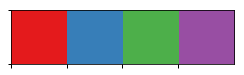

In [71]:
sns.palplot(colors)

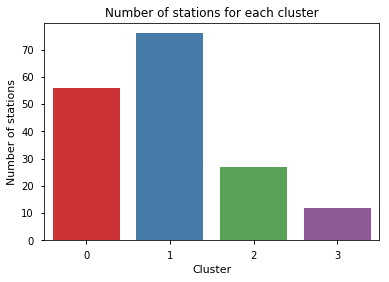

In [70]:
sns.barplot(x=label_count.index, y=label_count, palette=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of stations')
plt.title('Number of stations for each cluster')

Plot the daily profile of available bikes (%) for each cluster.

In [95]:
pd.DataFrame(kmeans.cluster_centers_).to_csv("../data/bordeaux_clusters.csv", index=False)

In [94]:
kmeans.cluster_centers_

array([[ 0.85612079,  0.90144269,  0.92701865,  0.93529502,  0.93635042,
         0.92984217,  0.91218976,  0.85143622,  0.67839165,  0.53811147,
         0.48767876,  0.45683496,  0.44343193,  0.4332927 ,  0.42625061,
         0.42879971,  0.428392  ,  0.46259526,  0.54899295,  0.64206451,
         0.67905327,  0.69504767,  0.72619311,  0.78652168],
       [ 0.88266194,  0.90293344,  0.92038195,  0.93411959,  0.94003019,
         0.9348597 ,  0.9163827 ,  0.90072124,  0.88410779,  0.87966202,
         0.87229049,  0.86141732,  0.85165133,  0.83614936,  0.83599821,
         0.83479042,  0.81898354,  0.80056498,  0.80174642,  0.81273062,
         0.81905851,  0.82179479,  0.82779762,  0.84520065],
       [ 0.31643453,  0.3001893 ,  0.29684107,  0.29803988,  0.30018171,
         0.30801922,  0.31882587,  0.35971205,  0.55797902,  0.85811351,
         0.91821378,  0.91469655,  0.85458968,  0.83590916,  0.87430805,
         0.83412739,  0.73269849,  0.54653792,  0.3934498 ,  0.33190782,
  

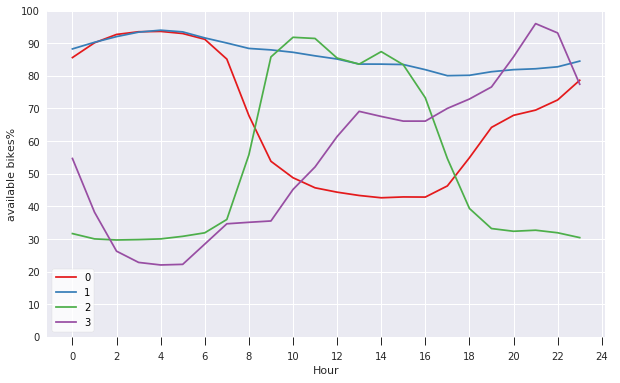

In [78]:
with sns.axes_style("darkgrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6))

for k, label, color in zip(kmeans.cluster_centers_, range(n_clusters), colors):
    plt.plot(100*k, color=color, label=label)
    
plt.legend()
plt.xlabel('Hour')
plt.xticks(np.linspace(0, 24, 13))
plt.yticks(np.linspace(0, 100, 11))
plt.ylabel("available bikes%")
sns.despine()
plt.savefig("../images/bordeaux-pattern.png")

## Map

Get the station lat/lon coordinates.

In [36]:
locations = pd.read_csv("../data/bordeaux-stations.csv")

In [37]:
locations.head()

,ident,nom,lat,lon
0,138,Lycée Brémontier,44.824055,-0.570243
1,135,Eglise Ste Croix,44.831312,-0.561393
2,79,Buttinière,44.864276,-0.524200
3,3,Porte de Bourgogne,44.837789,-0.567156
4,8,Doyen Brus,44.800385,-0.609857


In [38]:
dflabel = pd.DataFrame({"label": kmeans.labels_}, index=profile.columns)

In [39]:
dflabel.head()

,label
station,
1,2
2,2
3,1
4,2
5,2


Get the label, i.e. the cluster id, for each station.

In [40]:
locations = locations.merge(dflabel, right_index=True, left_on='ident')

In [41]:
locations.head()

,ident,nom,lat,lon,label
0,138,Lycée Brémontier,44.824055,-0.570243,0
1,135,Eglise Ste Croix,44.831312,-0.561393,0
2,79,Buttinière,44.864276,-0.524200,1
3,3,Porte de Bourgogne,44.837789,-0.567156,1
4,8,Doyen Brus,44.800385,-0.609857,2


In [42]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

In [43]:
import folium

In [44]:
# Bordeaux (France) position.
position = [44.836151, -0.580816]

In [79]:
mp = folium.Map(location=position, zoom_start=12, tiles='cartodbpositron')

In [80]:
hex_colors = colors.as_hex()

In [84]:
for _,row in locations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=row['nom'],
        color=hex_colors[row['label']],
        fill=False,
        fill_opacity=0.5,
        fill_color=hex_colors[row['label']]
    ).add_to(mp)

In [85]:
mp.save("../images/bordeaux-map-n_clusters-{}.html".format(n_clusters))

In [86]:
mp